# LLM From Stratch

## Table of content

[Introduction](#introduction)

[Goal](#goal)

[Chapter 1 - Tokenizer](#chapter-1---tokenizer)

- [1.1 - Data import](#data-import)

- [1.2 - Vocabulary](#vocabulary)

- [1.3 - Encoding and decoding](#encoding-and-decoding)

[Chapter 2 - Predictions from contexts](#chapter-2---predictions-from-contexts)

- [2.1 - Training and validation data](#training-and-validation-data)

- [2.2 - Contexts and targets](#contexts-and-targets)

- [2.3 - Batches](#batches)

[Chapter 3 - Neural network: Bigram model, generation and loss](#chapter-3---neural-network-bigram-model-generation-and-loss)

- [3.1 - Bigram model](#bigram-model)

- [3.2 - Model training and optimization](#32---model-training-and-optimization)

[Conclusion](#conclusion)

## Introduction

An AI LLM prototype written in plain python, only for personnal educational purpose.

It is a Generatively Pretrained Transformer (GPT), following the paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) and OpenAI's [GPT-2](https://huggingface.co/openai-community/gpt2) / [GPT-3](https://fr.wikipedia.org/wiki/GPT-3).

It was made for educationnal purpose only and understanding what is happening under the hood.

<strong> No AI were used in any of the project nor code. 100% human.</strong>

I tried to learn and resume a course based on those two great videos:

- [Andrej Karpathy - Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)

- [freeCodeCamp.org - Create a Large Language Model from Scratch with Python – Tutorial](https://www.youtube.com/watch?v=UU1WVnMk4E8)

Using these tools: 

- [Anaconda](https://www.anaconda.com/docs), langage distribution made for research and deep-learning

- [PyTorch](https://pytorch.org/), an optimized tensor library for deep learning

- [Nvidia CUDA API](https://www.anaconda.com/docs/getting-started/working-with-conda/packages/gpu-packages), for [GPU computation](https://en.wikipedia.org/wiki/General-purpose_computing_on_graphics_processing_units)

- [Jupyter Notebook](https://jupyter.org/), for creating and sharing computational documents ([web sample here](https://jupyter.org/try-jupyter/notebooks/?path=notebooks/Intro.ipynb)).

- [Ipykernel](https://pypi.org/project/ipykernel/), IPython Kernel for Jupyter, we'll use it for creating virtual environments

WORK IN PROGRESS.

## Goal

The main objective is to have a fully functionnal GPT that can generate text from pre-trained data.

## Chapter 1 - Tokenizer

A language model need need tokenized inputs to work.

This task is made by a tokenizer.

There are multiple type of tokenizer: 

- character-level, 

- word-level, 

- byte-pair-encoding (the most used and optimized option).

We will create our own tokenizer, but there are already a lot of existing ones, like:

- [tiktoken](https://github.com/openai/tiktoken), by OpenAI

- [tokenizers](https://huggingface.co/docs/tokenizers/index), an implementation of today's most used tokenizers by Hugging Face

- [SentencePiece](https://github.com/google/sentencepiece), used by Google

You can also use [OpenAI Tokenizer Playground](https://platform.openai.com/tokenizer) to test one in action.

### Data import

First, we need to read a text to create our vocabulary for training our model.

Andrej Karpathy used tinyshakespeare in his video, which contains Shakespeare's work in a single txt file.

I also recommand using the 1864 novel "[Journey to the Center of the Earth](https://www.gutenberg.org/cache/epub/18857/pg18857.txt)", by Jules Verne.

Taken from free-ebooks [Project Gutemberg website](https://www.gutenberg.org) where you can find more if you want.

In [ ]:
# Change this URL to modify data that the GPT will be trained on
file_url="https://www.gutenberg.org/cache/epub/18857/pg18857.txt"

# Fetch book plain text
file_path="data/input.txt";
!wget -O $file_path $file_url

In [ ]:
# We can also use data/chapter1.txt for a more lightweight input
file_path = "data/input.txt" 

# Fetch book content
file_descriptor = open(file_path, "r", encoding="utf8")
text = file_descriptor.read()

n = 200
print(text[:n])

### Vocabulary

A vocabulary is a finite set of words to train the model. 

Words not in the vocabulary are often replaced with a placeholder like <UNK> for “unknown.”

It will later be used to train our Bigram Model (see: Chapter 3).

In [ ]:
vocabulary = sorted(set(text)) # Sort vocabulary set in alphabetic order

print(''.join(vocabulary))

### Encoding and decoding

With this vocabulary, we can now create a tokenizer, that consists of two parts: 

- encode text into integers sorted set, 

- and decode integers input into original text.

This tokenizer works with char-level tokenizing, it means that in each prompt, it will encode each character. 

Each character will be affeted by an integer.

It is not the most efficient, but we are gonna stay on char-level to simplify the exercise.

In [ ]:
# create a mapping from characters to integers
def string_to_int():
   return { char:i for i, char in enumerate(vocabulary) }

# create a mapping from integers to characters 
def int_to_string():
   return { i:char for i, char in enumerate(vocabulary) }

print(int_to_string())

Then we can now use our converters to apply encoding and decoding:

In [ ]:
# take a string, output a list of integers
def encode(chars):
   return [ string_to_int()[c] for c in chars ]

# take a list of integers, output a string
def decode(integers):
   return ''.join([ int_to_string()[i] for i in integers ])

Now let's encode the entire text dataset. Here is an use example of the tokenizer:

In [ ]:
encoded_text = encode(text)
n = 50

print ("- Encoded data:", encoded_text[:n], "\n") # the characters we look at will to the GPT look like this
print ("- Decoded data:", decode(encoded_text[:n])) 

We store it into a torch.Tensor:

In [ ]:
import torch # PyTorch

data = torch.tensor(encoded_text, dtype=torch.long)
n = 50

print(data.shape, data.dtype)
print(data[:n]) # Print nth first encoded characters from the text

A torch.Tensor is a multi-dimensional matrix containing elements of a single data type (here numbers). See more in [documentation](https://docs.pytorch.org/docs/stable/tensors.html).

## Chapter 2 - Predictions from contexts

### Training and validation data

We splits data into prediction and validation, because we do not want to make the model to copy exactly the content of data, but try to product content similar to the data, not the exact one. 

So we never feed the entire data into the transform, but blocks of it.

We will use validation data in later chapters.

In [ ]:
percent = 0.9 # Splits data (90 % for training, 10% for validation)
split_length = int(len(data) * percent) # Calculated split length
 
train_data = data[:split_length+1] # first 90% data
validation_data = data[split_length:] # remaining 10% data

### Contexts and targets

The main goal of a model is from given context, achieve to predict what comes next. 

Context is by definition our input to the transformer.

For example, if our text data is "Hello":

- If context: "H" -> target would predict: "e",

- Then if context: "e" -> target would predict: "l",

- Then if context: "l" -> target would predict: "l",

- Then if context: "l" -> target would predict: "o".

It would be better to work with blocks of characters, to gains more accuraty, and generate texts from given one. 

For example, if we keep our text data as "Hello":

- If context: "H" -> target would predict: "e",

- Then if context: "He" -> target would predict: "l",

- Then if context: "Hel" -> target would predict: "l",

- Then if context: "Hell" -> target would predict: "o".


As you can see, a target always consists of the next predicted character, that comes after the context.

So we can agree that:

```python
context_block = data[:block_size]

target_block = data[1:block_size+1]
```

Here is an application, with a block size of 7 characters:

In [ ]:
block_size = 8

print("Training data:", train_data[:block_size])

In [ ]:
context_block = train_data[:block_size]
target_block = train_data[1:block_size+1]

print("Context block:", context_block)
print("Target block:", target_block)

In [ ]:
for i in range(block_size):
    
    context = context_block[:i+1]
    target = target_block[i]

    print("----------------------------------------------------------------------")
    print(f"Step {i+1} | context: {context}, target: {target}")
print("----------------------------------------------------------------------")

### Batches

In a block, it would be more efficient to analyse predictions in parallel within the block.

The goal is to simultaneously train every positions in the blocks, as they can be done in.

For example, in a chunck of 9 characters, there is actually 8 individuals step that we can process in parallel.

Each step from previous loop, can now become an parallel element of a batch.

So everytime we feed the transformer, it will have multiple batches of multiple chucks (or blocks) of text, all stored in a single tensor.

If batch_size == 4, a context batch would contains:

```md
[[83], [83, 39], [83, 39, 70], [83, 39, 70, 70]]
```

We implement batch creation and processing:

In [ ]:
import torch # We will use PyTorch framework

batch_size = 4 # How many independent sequence will we process in parallel

block_size = 7 # Maximum context length for predictions

# Generate a small batchof contexts x and targets y
# From encoded data
# Two possible splits: training or validation
def get_batch (split):

    # Permute data for training and validation cases
    data = train_data if split == "train" else validation_data
    
    # Create a tensor filled with random integers generated, of size batch_size
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Create context blocks from random coordinates
    x = torch.stack([data[i:i+block_size] for i in ix])

    # Create targets blocks from random coordinates
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    # Returns batch of data of contexts x and targets y
    return x, y

Use application:

In [ ]:
x_batch, y_batch = get_batch("train")

print(f"- contexts batch:\n{(x_batch)}\n")
print(f"- targets batch:\n{y_batch}\n")

We also do a print decoded batch for debug use:

In [ ]:
def print_decoded_batch(batch):
    for i in range (len(batch)) :
        decoded_text = decode((x_batch)[i].tolist())
        print(f"- decoded context {i+1}: {decoded_text}")
        
print_decoded_batch(x_batch)

To do parallel computing, the best option is to do [GPU computing (or GPGPU)](https://en.wikipedia.org/wiki/General-purpose_computing_on_graphics_processing_units) with [CUDA API](https://en.wikipedia.org/wiki/CUDA), but we will see this later.

## Chapter 3 - Neural network: Bigram model, generation and loss

### 3.1 - Bigram model

What is a bigram model ?

A bigram language statistical model is a language model that predicts the likelihood of a word given its preceding word. 

In other words, it models the probability of a word occurring based on the word that precedes it.

It is based on bigrams, but what are bigrams ?

[Bigrams](https://en.wikipedia.org/wiki/Bigram) are just every two words in these sentences coming one after another:

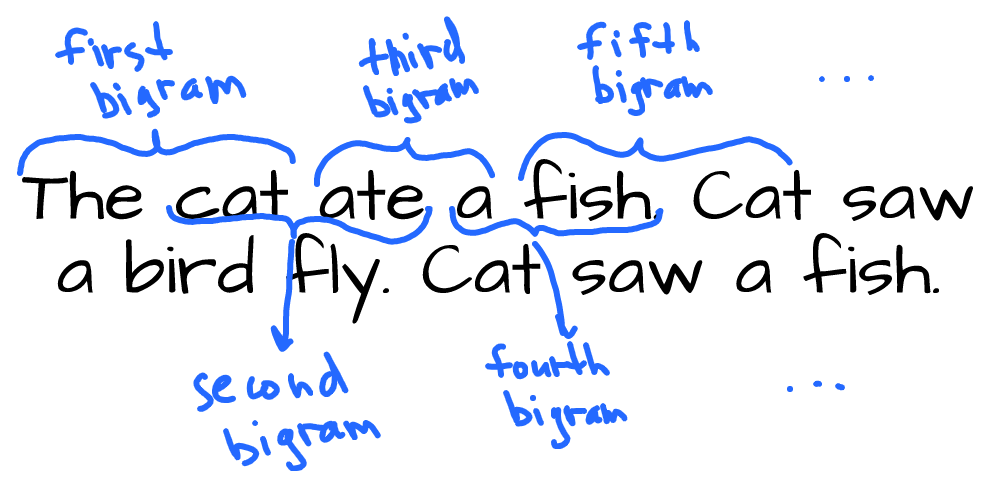

The schema of our model is the following:

- It will do predictions using forward, for both training and generating

- For training, we use targets to determine if predictions are correct

- For generation, we don't use targets, so they will be None by default

Here is the model implementation, using neural network Module of PyTorch.

In [ ]:
import torch.nn as nn # Neural network package
from torch.nn import functional as F # Functional package

class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocabulary_size):
        # initialize internal Module state, shared by nn.Module 
        super().__init__()
        
        # Each token directly reads off the logits for the next token from a vocabulary embedding
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)
    
    def forward(self, idx, targets=None):
        # Forward pass, from nn module 
        # the predict process is done here
        # there are no targets during generation, only in training
        # we will use forward for both cases
        
        # idx are the context batch
        # Definitions:
        # - Batch: batch size
        # - Time: context size
        # - Channels : vocabulary size
        # idx and targets are both (Batch, Time) tensor of integers
        
        # PyTorch will transform the result into a score of for the next character of the sequence
        logits = self.token_embedding_table(idx) # (B, T, C)
    
        # generation case
        if targets == None :
            loss = None
            
        # training case
        else :
            # Cross entropy demandes parameter order: (B, C)
            # We need to switch values (B, T, C) in logits (B, C) to do so
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # (B, C)
            targets = targets.view(B*T)

            # Evaluat how good are the predictions
            loss = F.cross_entropy(logits, targets) 
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
            # Generate max_new_tokens sized text from a given context text 
            # idx is (B, T) array of indices in the current context batch
            # max_new_tokens is the number of token the model can generate
        
            # The objective is to get (B, T) and extends it (generation) to 
            # (B,T+1), (B,T+2) + ... + (B, T + max_new_tokens)
            for _ in range(max_new_tokens):
                
                # get the predictions
                # we don't loss nor targets     
                logits, _ = self(idx)
                
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            # return previous context + generated text
            return idx
        

You can find here a [great explanation of forward pass](https://www.geeksforgeeks.org/deep-learning/understanding-the-forward-function-output-in-pytorch/).

Here is a application example of our model (in a training case):

In [ ]:
# Create our language model
model = BigramLanguageModel(len(vocabulary))

# Create a training batch
# With x our context, and y our targets
x_batch, y_batch = get_batch("train")

# Call foward method, do training because we gave it targets (y_batch)
output,  loss = model(x_batch, y_batch)

print(f"Output shape (B*T,C): {output.shape}")
print(f"Loss: {loss}")

Here is a application of model text generation:

In [ ]:
# Initial context (with only zeros)
idx = torch.zeros((1,1), dtype=torch.long)
max_new_tokens = 100

batched_generated_text = model.generate(idx, max_new_tokens)
generated_text = batched_generated_text[0].tolist()

print (f"\nInitial context:\n{idx.shape},{idx}\n")
print (f"Generated text:{decode(generated_text)}")


The model can now generate text similar !
But the generated looks ridiculous, because it is random.

We need now to train and optimize our model.

### 3.2 - Model training and optimization

There already are multiple optimizer provided by PyTorch, we will use here AdamW:

In [ ]:
batch_size = 32

def train_model(steps):
    # Train and otpimize model    
    
    if model == None:
        return
    
    # Create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    # Do steps number of training
    for _ in range(steps):
        # sample batch of data
        x_batch, y_batch = get_batch("train")

        # evaluate the loss
        _, loss = model(x_batch, y_batch)
        
        # reset the gradients of all optimized torch.Tensor
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print(loss)
       
train_model(10999)

## Conclusion